# Fujitsu IP Analytics
## Project: Backorders prediction

This project analyses the data from a distributor.

## Getting Started
Loading the dataset

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [8]:
# Load the backorders training dataset
try:
    data = pd.read_csv('backorderTrain.csv',header =0)
    print "backorders dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

backorders dataset has 1693050 samples with 23 features each.


## Data Exploration
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [9]:
#create label array and drop it from features
data.set_index('sku', inplace =True)
labels = data.went_on_backorder
labels.replace('No',0, inplace=True)
labels.replace('Yes',1, inplace=True)
data.fillna(0,inplace =True)
#data.drop('went_on_backorder',axis=1, inplace =True)

In [10]:
# Display a description of the dataset
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop']:
        data[col] = (data[col] == 'Yes').astype(int)
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693050 entries, 2079834 to 4960973
Data columns (total 22 columns):
national_inv         int64
lead_time            float64
in_transit_qty       int64
forecast_3_month     int64
forecast_6_month     int64
forecast_9_month     int64
sales_1_month        int64
sales_3_month        int64
sales_6_month        int64
sales_9_month        int64
min_bank             int64
potential_issue      int32
pieces_past_due      int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         int64
deck_risk            int32
oe_constraint        int32
ppap_risk            int32
stop_auto_buy        int32
rev_stop             int32
went_on_backorder    int64
dtypes: float64(3), int32(6), int64(13)
memory usage: 258.3 MB


None

### Data Analysis on Exoplanet data
i will select the data from class 2 and explore it in more detail

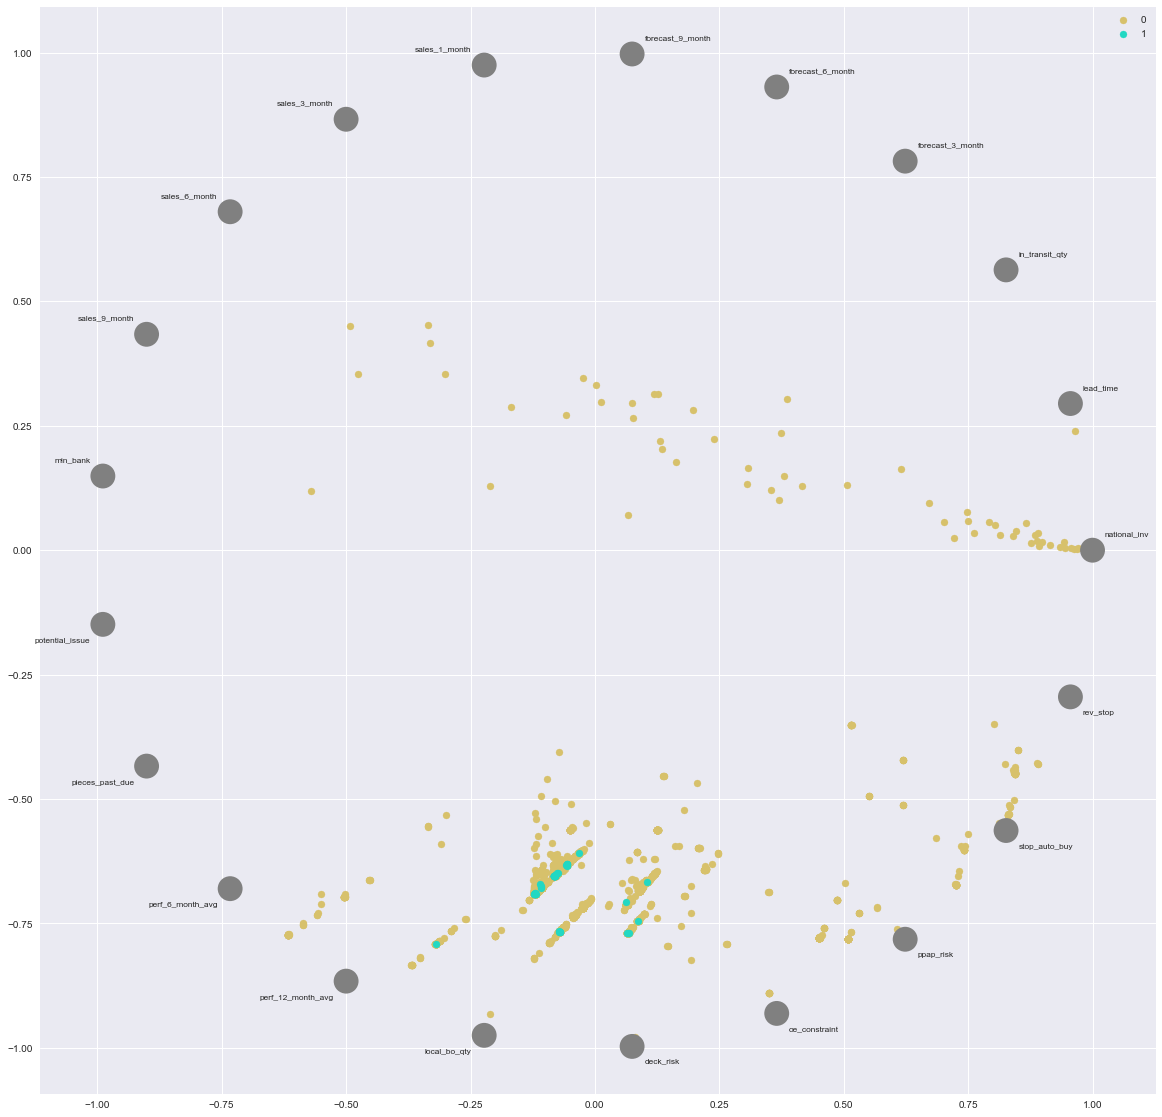

In [21]:
# Create a DataFrame of the chosen samples
plt.figure(figsize =(20,20))
pd.tools.plotting.radviz(data.sample(10000), 'went_on_backorder')

In [62]:
# min value = -9.900000e+01
# max value =  1.228510e+07
delta = np.subtract(1.228510e+07,-9.900000e+01)
print delta
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(1, delta), copy=True)
log_data = pd.DataFrame(mms.fit_transform(data), columns = data.keys(), index = data.index)
log_data = np.log(log_data)
display(log_data.head())

12285199.0


,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
sku,,,,,,,,,,,,,,,,,,,,,
2079834,10.415009,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079835,10.414380,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079836,10.414500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079837,10.416920,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.905493,3.003931,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,16.323906,0.0
2080337,10.423701,0.0,0.0,0.0,0.0,0.0,0.0,2.425055,2.905493,3.764966,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,0.000000,0.0


In [29]:
#Normalise the data using the standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=True, with_std=True)
data.drop('went_on_backorder',axis=1, inplace =True)
norm_data = pd.DataFrame(sc.fit_transform(data), columns = data.keys(), index = data.index)

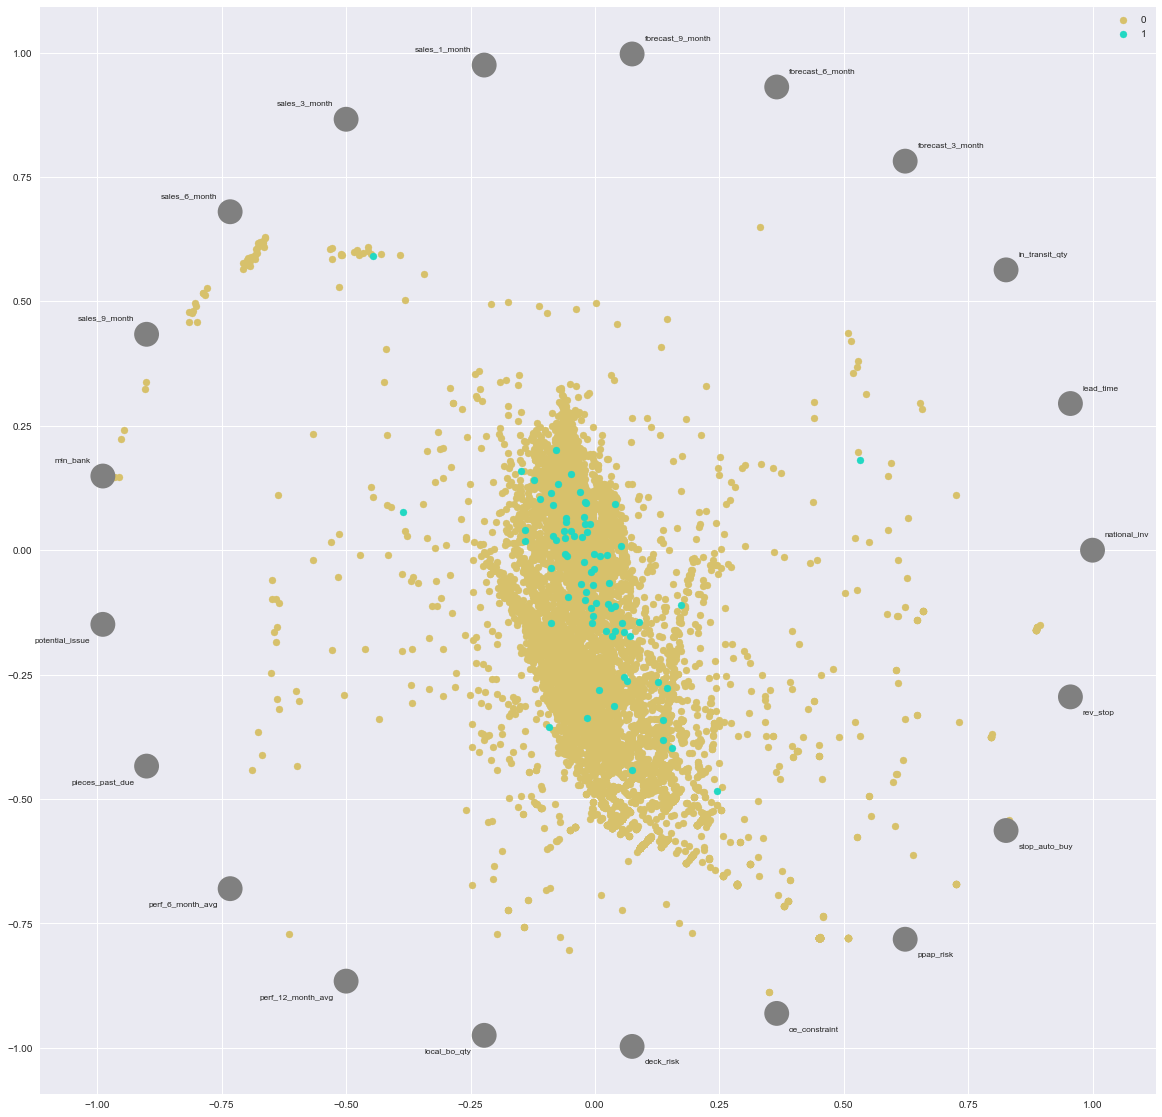

In [59]:
# Create a DataFrame of the chosen samples
plt.figure(figsize = (20,20))
#pd.tools.plotting.radviz(norm_data.sample(10000), 'went_on_backorder')
#display(norm_data.head())
samples = log_data
samples['label'] = labels
#display(samples.head())
pd.tools.plotting.radviz(samples.sample(10000), 'label')

In [43]:
# For each feature find the data points with extreme high or low values
cnt = hp.find_outliers(log_data)

In [55]:
OnePer = int(len(data['national_inv'])/100)
print "remove 1% of the outliers which is: {} ".format(OnePer)
print len(list(cnt.most_common()))

remove 1% of the outliers which is: 16930 
941117


In [ ]:
#plot the most common outlier
outliers = list(cnt.most_common(OnePer))
#fig = plt.figure(figsize=(20,40))
for i in range(OnePer):
    outliers[i] = int(outliers[i][0])
    #ax = fig.add_subplot(12,3,i+1)
    #plt.title(labels[outliers[i]])
    #ax.scatter(x,data.iloc[outliers[i],:])

In [ ]:
#remove the 1% outliers
#display(norm_data.loc[outliers])
good_data = norm_data.drop(outliers)
good_lables = labels.drop(outliers)
#save data
pickle.dump((good_data,good_lables), open('good_data_trainset.p', 'wb'))

In [2]:
#load data
good_data, good_lables = pickle.load(open('good_data_trainset.p', mode='rb'))

## class imbalance correction
at this point we are ready to apply correction for class imbalance

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(good_data, good_lables,stratify =good_lables, test_size=0.4, random_state=42)

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio = 0.017,random_state =42,k_neighbors =2,kind = 'borderline1')
st = SMOTETomek(smote = sm, ratio= 0.017, random_state = 42)
X_resampled, y_resampled = st.fit_sample(good_data, good_lables)

In [ ]:
vs_class_imbalance(good_data, good_lables,X_resampled, y_resampled)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
#save data
pickle.dump((X_train, y_train), open('SmoteTomek-Train.p', 'wb'))
pickle.dump((X_test, y_test), open('SmoteTomek-Validation.p', 'wb'))

## Checkpoint
resampled data saved
## Feature Transformation
### application of PCA looking for best number of features
explained variance on training set
* Dimension 1     0.4829
* Dimension 2     0.8346
* Dimension 3     0.8847
* Dimension 4     0.9226
* Dimension 5     0.9438
* Dimension 6     0.9620
* Dimension 7     0.9772
* Dimension 8     0.9830
* Dimension 9     0.9855
* Dimension 10    0.9874

In [ ]:
# Load the Preprocessed data
X_train, y_train = pickle.load(open('SmoteTomek-Train.p', mode='rb'))
X_val, y_val = pickle.load(open('SmoteTomek-Validation.p', mode='rb'))
# Load the Preprocessed data
#X_train, y_train = pickle.load(open('EasyEnsemble-Train.p', mode='rb'))
#X_val, y_val = pickle.load(open('EasyEnsemble-Validation.p', mode='rb'))

In [ ]:
pca = PCA(n_components=30, random_state = 42).fit(X_train)
#pca_results = vs_pca_results(X_train,pca)
#X_trainPCA = pca.transform(X_train)
#X_testPCA = pca.transform(X_val)

### Visualize Data
since with 2 dimention we can describe 83.4% of the data we are able to plot a scatted of it

In [ ]:
print sum(pca.explained_variance_ratio_ )

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

#Initialize the three models
clf_A = DecisionTreeClassifier(random_state = 42)
clf_B = GaussianNB()
clf_C = GradientBoostingClassifier(n_estimators =250, max_depth= 7,min_impurity_split= 100000.0,random_state = 42)
tot_training = X_train.shape[0]

#Calculate the number of samples for 1%, 10%,100% of the training data
samples_1 =   int(tot_training * 0.01)
samples_10 =  int(tot_training * 0.1)
samples_100 = int(tot_training * 0.5)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        hp.train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
hp.evaluate(results, 0.3, 0.3)

In [ ]:
def vs_frontiers(good_data,good_lables,outliers):
    print(__doc__)

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager
    from sklearn import svm
    pca = PCA(n_components=2, random_state = 42)
    #X_train, X_test, y_train, y_test = train_test_split(good_data[good_lables ==0].sample(10000), good_lables[good_lables ==0].samlep(10000), test_size=0.4, random_state=42)
    #xx, yy = np.meshgrid(good_data,500,sparse=True)
    xx, yy = np.meshgrid(np.linspace(-20, 20, 600), np.linspace(-20,20, 600))

    X_train = pca.fit_transform(good_data[good_lables == 0].sample(40000))
    X_test = pca.transform(good_data[good_lables == 0].sample(10634))
    X_outliers = pca.transform(good_data[good_lables == 1])
    X_TrainOUTliers = pca.transform(outliers[good_lables == 0])

    # fit the model
    clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma=0.045).fit(X_train)
    #predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers =clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,20))
    plt.title("Novelty Detection")
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    s = 30
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    d = plt.scatter(X_TrainOUTliers[:, 0], X_TrainOUTliers[:, 1], c='red', s=s)
    plt.axis('tight')
    plt.xlim((-5, 20))
    plt.ylim((-10, 10))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel(
        "error train: %d/40000 ; errors novel regular: %d/10634 ; "
        "errors novel abnormal: %d/10634"
        % (n_error_train, n_error_test, n_error_outliers))
    plt.show()
#vs_frontiers(good_data,good_lables)

outliersdf = log_data.loc[list(cnt)]
display(outliersdf.head())
vs_frontiers(log_data,labels, outliersdf[labels == 0])

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
sku,,,,,,,,,,,,,,,,,,,,,
2097152,10.415009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.425055,2.527021,2.525632,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2097153,10.421178,0.000000,5.021331,0.000000,0.000000,5.031562,5.854515,6.523545,6.833087,6.829508,...,0.0,0.0,16.313855,16.313855,0.0,0.000000,0.0,0.0,0.000000,0.0
2097154,10.416144,14.857569,5.711175,4.875765,5.685144,5.816452,5.115727,5.972558,6.252342,6.432835,...,0.0,0.0,16.323105,16.323206,0.0,0.000000,0.0,0.0,16.323906,0.0
2097155,10.414769,0.000000,0.000000,0.000000,0.000000,0.000000,2.865748,2.425055,2.527021,2.159391,...,0.0,0.0,0.000000,0.000000,0.0,16.323906,0.0,0.0,16.323906,0.0
2097156,10.415487,14.452104,7.486195,0.000000,0.000000,5.588376,5.583477,6.184632,6.306308,6.294238,...,0.0,0.0,16.323806,16.323306,0.0,0.000000,0.0,0.0,16.323906,0.0


C:\Users\andre\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Automatically created module for IPython interactive environment


C:\Users\andre\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [63]:
display (log_data.head())

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
sku,,,,,,,,,,,,,,,,,,,,,
2079834,10.415009,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079835,10.414380,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079836,10.414500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,16.323906,0.0
2079837,10.416920,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.905493,3.003931,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,16.323906,0.0
2080337,10.423701,0.0,0.0,0.0,0.0,0.0,0.0,2.425055,2.905493,3.764966,...,0.0,0.0,0.0,0.0,0.0,16.323906,0.0,0.0,0.000000,0.0


In [107]:
#setting up the benchmark
from sklearn import svm
X_train = good_data[good_lables == 0].sample(40000)
#X_test = pca.transform(good_data[good_lables == 0].sample(10000))
#X_outliers = pca.transform(good_data[good_lables == 1])
# fit the model
clf = svm.OneClassSVM(nu=0.4, kernel="rbf", gamma=0.04).fit(X_train)
#predict
#y_pred_train = clf.predict(X_train)
#y_pred_test = clf.predict(X_test)
#y_pred_outliers =clf.predict(X_outliers)
#print y_pred_train[y_pred_train == -1].size
#print y_pred_test[y_pred_test == -1].size
#print y_pred_outliers[y_pred_outliers == 1].size

### Model Selection and optimisation


### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [ ]:
from imblearn.metrics import sensitivity_specificity_support
y_pred = clf.predict(good_data)
st, sp, su = sensitivity_specificity_support(good_lables,y_pred)
print 'sensitivity: {}, specitivity: {}, support : {}'.format(st, sp, su)
display(y_pred)

In [ ]:
print cnt

In [101]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest
def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """    
    # This dataset is too high-dimensional. Better do PCA:
    pca = PCA()

    # Maybe some original features where good too?
    selection = SelectKBest(k=1)
    
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
    
    #set the pipeline
    pipeline = Pipeline([("features", combined_features), ("svm", svm.OneClassSVM)])
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    ##test:
    ##learning_rate: (0.1,0.08,0.01,0.5)n_estimators:(50,100,180,200,250)max_depth(3,4,5,6,7,8,10)
    param_grid = dict(features__pca__n_components=[1, 2, 3, 4, 5],
                  features__univ_select__k=[1, 2],
                  svm__nu = [0.1,0.5,0.7],
                  svm__gamma=[0.05, 0.03, 0.01])

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(sensitivity_specificity_support)

    # TODO: Create the grid search object
    grid = GridSearchCV(pipeline, params,scoring = scoring_fnc,cv = cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [ ]:
# Fit the training data to the model using grid search
clf = fit_model(X_trainPCA, y_train)
print 'operation completed'
# Produce the value for 'max_depth'
#print "Parameter 'max_depth' is {} for the optimal model.".format(clf.get_params()['max_depth'])

In [ ]:
display(clf.get_params())

## loading testing data
now load the test data and test on the classifier.

In [ ]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)
#    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
#except:
#    print "Dataset could not be loaded. Is the dataset missing?"

In [ ]:
#create label array and drop it from features
testlabels = Testdata.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result

In [ ]:
X_test = pca.transform(Testdata)
y_pred = clf_C.predict(X_test)
print classification_report(testlabels, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(100*cm/float(cm.sum()))
ax = sns.heatmap(df_cm.round(2), annot=True, cmap='Greys', fmt='g', linewidths=1)
ax.set_title("Confusion Matrix - per 100 predictions")
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16, rotation=90)
plt.show()